# Proyecto 6: Sistemas de recomendación

## Dataset

El dataset que vamos a usar en este proyecto es el del proyecto [MovieLens](http://grouplens.org/datasets/movielens/). Estos son relevados por el grupo de investigación GroupLens de la Universidad de Minnesota. Vamos a usar la versión 100K.

Está basado en un sistema de rating de 5 estrellas y texto libre para tags a partir del servicio de recomendaciones MovieLens. Contiene 100.000 ratings para 1.682 películas. Los datos fueron creados por 943 usuarios.

En el [Readme](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt) del dataset se puede encontrar información adicional. A continuación vamos a describir cada uno de ellos.

### Ratings (u.data)

Cada línea representa el rating para una película para un usuario. Los ratings están basados en un sistema de 5 estrellas, con una salto de 0.5 estrellas. Los timestamps están expresados en segundos desde la medianoche de 01/1970 (UTC). El formato es:

`user id | item id | rating | timestamp`

### Usuarios (u.users)

Cada línea del archivo representa un usuario. Se incluye información demográfica. El formato es:

`user id | age | gender | occupation | zip code`

### Películas (u.item)

Cada línea corresponde a una película. Puede haber inconsistencias en los nombres. El formato es:

`movie id | movie title | release date | video release date | IMDb URL | generos`



Las columnas con los generos son binarias indicando la presencia o ausencia de cada uno en la película. Los géneros pueden ser:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* unknown

## Experimentación

Durante todo este proyecto vamos a utilizar la librería `surprise` para llevar a cabo las experimentaciones.

Como se mencionó en clase, las implementaciones en esta librería tiene algunas mejoras respecto de las estrategias convencionales como SVD. Esto se traduce en una mayor cantidad de parámetros para optimizar.

Vamos a levantar los datos. En primer lugar, definamos el formato para poder leer los datos.

**1) Utilizar** el `Reader` con el parámetro `line_format` igual a `'user item rating timestamp'` y `sep` como `'\t'`. Guardarlo en una variable `reader`.

In [1]:
import surprise
from surprise import Dataset
from surprise import Reader

Utilizando este `reader` cargar los datos:

In [2]:
reader = surprise.reader.Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_file('./dataset/ml-100k/u.data', reader=reader)

In [3]:
# print(len(data.raw_ratings))
# data.raw_ratings

__2) Ejecutar una corrida inicial usando cross validation y el algoritmo SVD (5 folds). Imprimir los RMSE de testing.__

In [4]:
from surprise import SVD
from surprise.model_selection import cross_validate, KFold

folds = KFold(n_splits=5, random_state=42)

svd = SVD()
cv = cross_validate(svd, data, measures=['RMSE'], cv=folds, verbose=True, n_jobs=-1)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9388  0.9325  0.9431  0.9332  0.9350  0.9365  0.0039  
Fit time          8.03    8.75    9.50    9.25    8.54    8.81    0.52    
Test time         0.29    0.32    0.30    0.19    0.17    0.26    0.06    


__3) Evaluar el RMSE (promedio de cross validation) de testing de acuerdo a la cantidad de factores en SVD.__

In [5]:
import numpy as np
rmse_test_means = []

factores = [10,100,200,500,1000]
for factor in factores:
    svd = SVD(n_factors=factor)
    cv = cross_validate(svd, data, measures=['RMSE'],  cv=folds, verbose=False, n_jobs=-1)
    rmse_test_means.append(np.mean(cv['test_rmse']))

In [6]:
rmse_test_means

[0.9358578733788999,
 0.9355017654616665,
 0.9410218191632914,
 0.9554775071737845,
 0.9707053603638448]

__4) Graficar los promedios RMSE del conjunto de testing de acuerdo a la cantidad de factores en SVD.__

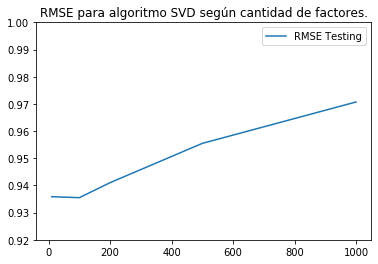

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(factores, rmse_test_means, label='RMSE Testing')
plt.ylim((0.92, 1.0))
plt.legend(loc="best")
plt.title("RMSE para algoritmo SVD según cantidad de factores.")
plt.show()

__5) Usando GridSearch, encontrar el mejor estimador usando SVD con 500 factores. Imprimir el mejor rmse. Utilizar `refit` para obtener obtener el mejor estimador ya ajustado como resultado.__

Utilizar el espacio de parámetros:
* n_epochs: [5, 10]
* lr_all: [0.002, 0.005]
* reg_all: [0.4, 0.6]


In [8]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10], 
              'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6],
              'n_factors': [500]}

grid_search = GridSearchCV(SVD, param_grid, refit=True, measures=['rmse'], cv=folds, n_jobs=-1)

grid_search.fit(data)


In [9]:
print(grid_search.best_params['rmse'])

{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4, 'n_factors': 500}


In [10]:
print(grid_search.best_score['rmse'])

0.9617313438923689


In [11]:
algo = grid_search.best_estimator['rmse']

__6) Obtener una predicción para el usuario 321 para la película Titanic.__

In [12]:
import pandas as pd
df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'TimeStamp'])
df.head()

,user_id,item_id,rating,TimeStamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [13]:
df = df.drop('TimeStamp', axis=1) #dropeo la columna porque no tiene información necesaria y el reader necesita 3 columnas.
reader = Reader()
data = data.load_from_df(df, reader)
data

In [14]:
items = pd.read_table('./dataset/ml-100k/u.item', sep='\t', delimiter='|', encoding='ISO-8859-1', header=None, index_col = 0, usecols = [0,1], names = ['item_id', 'Name'])
df_items = pd.DataFrame(items)
df_items.head()

,Name
item_id,
1,Toy Story (1995)
2,GoldenEye (1995)
3,Four Rooms (1995)
4,Get Shorty (1995)
5,Copycat (1995)


In [15]:
#Buscador de item por nombre de pelicula 
Name = 'Titanic'
itemid = df_items.loc[df_items.Name.str.contains(Name)].index.values[0]

In [16]:
i_id = str(itemid)
u_id = str(321) 

In [17]:
#Buscador por item
df[df.item_id == i_id]

,user_id,item_id,rating
1698,240,313,5.0
1900,134,313,5.0
2030,319,313,5.0
2447,111,313,4.0
2467,236,313,4.0
...,...,...,...
99401,829,313,4.0
99817,818,313,4.0
99830,487,313,3.0
99890,838,313,5.0


In [18]:
#Buscador por usuario 
df[df.user_id == u_id]

,user_id,item_id,rating
1939,321,496,4.0
2220,321,287,3.0
3707,321,631,4.0
3818,321,131,4.0
4020,321,134,3.0
...,...,...,...
94817,321,498,5.0
94880,321,52,3.0
97018,321,428,4.0
97523,321,59,4.0


In [19]:
algo.predict(u_id, i_id, r_ui=None, verbose=True)

user: 321        item: 313        r_ui = None   est = 3.98   {'was_impossible': False}


Prediction(uid='321', iid='313', r_ui=None, est=3.9826563637516053, details={'was_impossible': False})

In [20]:
algo.default_prediction() #Para comparar la prediccion obtenida con la media global de todos los ratings.

3.52986

__7) Desarrollar una función que dado un usuario, obtenga la mejor predicción disponible (de acuerdo a nuestros datos de películas).__

In [21]:
def mi_prediccion(usuario):

    df_user = df[(df['user_id'] == usuario)]
    df_user = df_user.reset_index(drop=True)
    df_user['Name'] = df_items['Name'].loc[df_user.item_id.astype(int)].values #paso a int porque originalmente son strings

    recomendaciones_usuario = df_items.iloc[:4499].copy()
    
    usuario_vistas = df[(df['user_id'] == usuario)]
    
    recomendaciones_usuario.drop(index=usuario_vistas['item_id'].astype(int), inplace=True)
    recomendaciones_usuario = recomendaciones_usuario.reset_index()

    recomendaciones_usuario['Rating_Estimado'] = recomendaciones_usuario['item_id'].apply(lambda x: algo.predict(usuario, x).est)
    recomendaciones_usuario = recomendaciones_usuario.sort_values('Rating_Estimado', ascending=False)
       
    return recomendaciones_usuario.head(1)

In [22]:
usuario = str(1) #Menor a 944
mi_prediccion(usuario)

,item_id,Name,Rating_Estimado
0,273,Heat (1995),3.584429
